In [1]:
import open3d as o3d
import numpy as np
import copy

from Eval.Mesh import CreatePointcloudFromMeshVertices
from Eval.Clouds.Sphere import CreateBaseSpherePointCloud
from Eval.Error import CalculateRMSE
from Eval.Plotting import plot_technique_rmse
from Utils.Data import saveJSON, loadJSON

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Create Base Clouds for Comparison, Created Programatically for High Accuracy.

baseSphere = CreateBaseSpherePointCloud(diameter = 1.0, resolution=5000)


In [3]:
# Get the Obtained Data Clouds for Comparison, on the Base Programatically Created Clouds.

eval = 'kinect'

evalDataDir = f'../data/{eval}/sphere.ply'

collectedSphere = CreateBaseSpherePointCloud(diameter = 1.34, resolution=3000) # Temp For RMSE Collection Testing
#collectedSphere = CreatePointcloudFromMeshVertices(evalDataDir)

In [4]:
# Perform ICP Registration to Obtain a Transformation Matrix
# This allows for more accurate comparison of the clouds, by making them similar positioning.


icpRegResults = o3d.pipelines.registration.registration_icp(baseSphere, 
                                                            collectedSphere, 
                                                            0.1, 
                                                            np.identity(4), 
                                                            o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
                                                            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(icpRegResults)

# Apply the Transformation Matrix to the Obtained Data Clouds

baseSphere.transform(icpRegResults.transformation)

RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


PointCloud with 5000 points.

In [5]:
# Quick Visualization of both the Obtained Cloud and the Base Cloud.

baseTemp = copy.deepcopy(baseSphere)
baseTemp.paint_uniform_color([0.5, 0.5, 0.5])

targetTemp = copy.deepcopy(collectedSphere)
targetTemp.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries(
    [baseTemp, targetTemp],
    window_name="Base Sphere vs Target Sphere",
    width=800, 
    height=600
)

In [6]:
# Calculate the RMSE between the two clouds.

rmse = CalculateRMSE(baseSphere, collectedSphere)

print(f'RMSE: {rmse}')

RMSE: 0.17067869267933256


In [7]:
# Add the RMSE to the data file.

data = loadJSON("../data/techniques-rmse-diagram.json")

# Update the sphere RMSE value of data's technique.
dataBuff = data[eval]["sphere"]
print(dataBuff)

data[eval]["sphere"].update({
    "rmse": rmse,
    "inlier_rmse": icpRegResults.inlier_rmse
})

saveJSON("../data/techniques-rmse.json", data)
print(f'RMSE Data: \n{data}')

{'rmse': 0.17067957704413353, 'inlier_rmse': 0.0}
RMSE Data: 
{'point_e': {'sphere': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}, 'box': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}}, 'kinect': {'sphere': {'rmse': 0.17067869267933256, 'inlier_rmse': 0.0}, 'box': {'rmse': 0.17068033914497466, 'inlier_rmse': 0.0}}}


RMSE Data: 
{'sphere': [0.17068160383701134, 0.17067869267933256], 'box': [0.17068160383701134, 0.17068033914497466]}


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (2,).

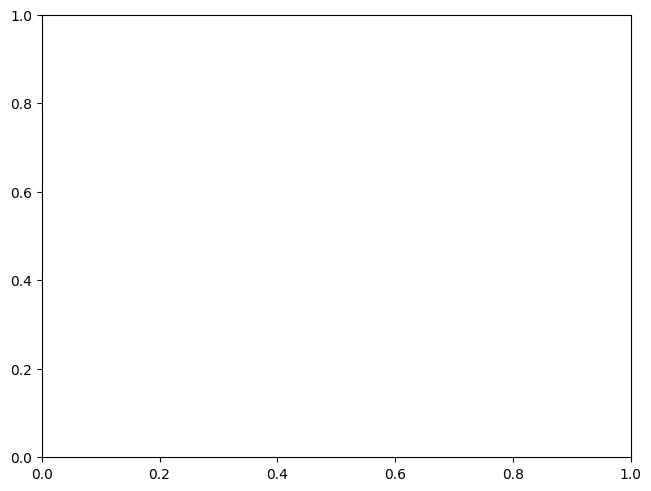

In [8]:
# Create Figure Based on Current Dataset

fig = plot_technique_rmse(data)

fig.show()

In [ ]:
# Save Figure

fig.savefig("../data/techniques-rmse.png", format="png", dpi=300)